In [1]:
import numpy as np
import random
import time
from IPython.display import clear_output
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
env = gym.make("FrozenLake-v0")
INPUT_DIM = (1)
OUTPUT_DIM = 4

In [3]:
def calculateAvgReward(num_episodes,avg_num_episodes,rewards_all_episodes):
        results = []
        rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/avg_num_episodes)
        count = avg_num_episodes
        for r in rewards_per_thousand_episodes:
#             avg_per_thousand_episode = str(sum(r/self.avg_num_episodes))
            sum_of_rewards = sum(r/avg_num_episodes)
            results.append({"episode":count,"reward":sum_of_rewards})
            count += avg_num_episodes
        return results
    
def createLinePlotForRewards(results,avg_num_episodes):
        df = pd.DataFrame(results)
        fig, ax1 = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=df, x="episode", y="reward", ax=ax1, ci=None)
        ax1.set_ylabel('Rewards',fontsize=13)
        ax1.set_xlabel('Episodes',fontsize=13)
        ax1.set_title("Average reward per "+str(avg_num_episodes)+" episodes",fontsize=16)

In [4]:
class DQNAgent:
    def __init__(self):
        self.num_episodes = 10000
        self.avg_num_episodes = round(self.num_episodes/10)
        self.learning_rate = 0.1
        self.exploration_rate = 0.95
        self.max_exploration_rate = 1
        self.min_exploration_rate = 0.01
        self.exploration_decay_rate = 0.9995
        self.decay_rate = 0.95
        self.model = self.build_model()
        self.opt = tf.optimizers.SGD(self.learning_rate,momentum=0.9)
        self.Hloss = tf.keras.losses.Huber()
    
    def build_model(self):
        inputs = tf.keras.layers.Input(INPUT_DIM)
        net = tf.keras.layers.Dense(64,activation='tanh')(inputs)
        net = tf.keras.layers.Dense(64,activation='tanh')(net)
        outputs = tf.keras.layers.Dense(OUTPUT_DIM)(net)
        model = tf.keras.Model(inputs,outputs)
        return model
    def loss_grads(self,state, target):
        with tf.GradientTape(persistent=True) as tape:
            pred = self.model(np.array([np.array(state)]))
#             loss = tf.reduce_mean(tf.square(pred-target))
#             huber loss
            loss = self.Hloss(target,pred)
            
        grads = tape.gradient(loss,self.model.trainable_variables)
        return loss, grads

    def act(self,state):
        # Exploration-exploitation trade-off
        self.exploration_rate_threshold = random.uniform(0, 1)
        if self.exploration_rate_threshold > self.exploration_rate:
            output = self.model(np.array([state]))[0]
#             print('output:', output)
            if np.isnan(output).any():
                print('NN broken or None')
                return -1
            action = np.argmax(output) # Exploitation
        else:
            action = env.action_space.sample() # Exploration
            
        return action
    
    def nural_net(self):
    
        rewards_all_episodes = []
        EMA = 0
        EMA_alpha = 0.001
        EMVar = 1
        state_max = 15
        
        # Q-Learning algorithm
        for episode in range(self.num_episodes):
            clear_output(wait=True)
            print("*****EPISODE ", episode+1, "*****\n\n\n\n")
            state = env.reset() / state_max

            done = False
            rewards_current_episode = 0

            while not done:    
                if done == True:
#                     env.render()
                    if reward == 1:
                        print("****You reached the goal!****")
                        time.sleep(2)
                    else:
                        print("****You fell through a hole!****")
                        time.sleep(1)
                        clear_output(wait=True)
                    break
                else:
#                     env.render()
#                     print('state:',state )
                    action = self.act(state)
                    
                    new_state, reward, done, info = env.step(action)
                    new_state = new_state / state_max
                    
                    prev_state = state
                    prev_pred = self.model(np.array([prev_state]))
                    prev_action = tf.argmax(prev_pred[0])
                    
                    curr_state = new_state

                    curr_pred = self.model(np.array([curr_state]))

                    curr_value = tf.reduce_sum(curr_pred)
                    
                    #compute value function
                    value = reward * 10 + self.decay_rate * curr_value
                    
                    #compute exponential moving variance
                    delta = value - EMA
                    EMA = EMA + EMA_alpha * delta
                    EMVar = (1 - EMA_alpha) * (EMVar + EMA_alpha * delta**2)
                    
                    #print(value,reward,prev_pred[0])
                    
                    #compute normalised target
                    target = prev_pred.numpy()
                    target[0][prev_action] = value / EMVar ** 0.5
                    
                    loss,grads = self.loss_grads(prev_state, target)
#                     print('loss:',loss.numpy())
                    self.opt.apply_gradients(zip(grads,self.model.trainable_variables))

                    state = new_state
                    rewards_current_episode += reward
            
            if self.exploration_rate > self.min_exploration_rate:
                self.exploration_rate *= self.exploration_decay_rate
                    
#             # Exploration rate decay
#             self.exploration_rate = self.min_exploration_rate + \
#                 (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate*episode)
            rewards_all_episodes.append(rewards_current_episode)
        return self.num_episodes,self.avg_num_episodes,rewards_all_episodes

In [5]:
agent = DQNAgent()
num_episodes,avg_num_episodes,rewards_all_episodes = agent.nural_net()

*****EPISODE  10000 *****






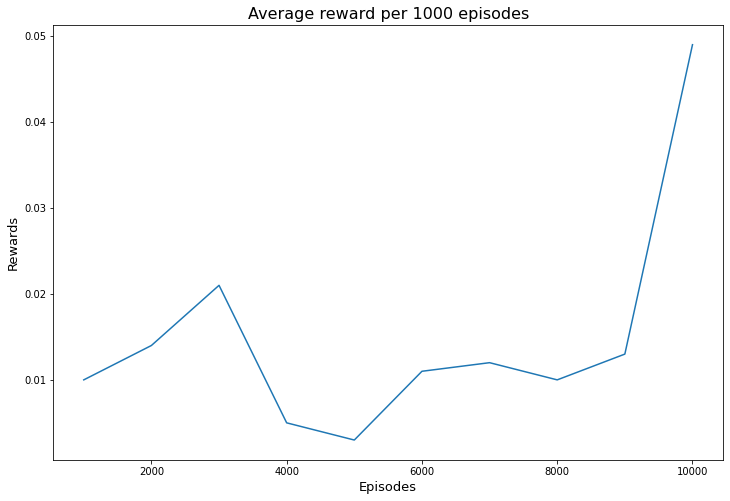

In [6]:
results = calculateAvgReward(num_episodes,avg_num_episodes,rewards_all_episodes)
createLinePlotForRewards(results,avg_num_episodes)